# Problem 1: Network Compression Using SVD

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import GRU, Input, Flatten, Dense, Dropout, Conv2D, MaxPool2D, Dot
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import os
import librosa
from IPython.display import Audio
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
import math
from tqdm import tqdm
from itertools import combinations
from tensorflow.keras.metrics import BinaryAccuracy
import random




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Training MNIST Classifier

Train a fully-connected net for MNIST classification. It should be with 5 hidden layers each of which
is with 1024 hidden units. Feel free to use whatever techniques you learned in class. You should be
able to get the test accuracy above 98%. Let’s call this network “baseline”

### Data Pre-Processing for MNIST Classifier

Once the data is load, it is normalized

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Model Definition and Training

In [5]:
baseline_model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(10, activation='softmax')
])

baseline_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

baseline_model.fit(train_images, train_labels, epochs=20, validation_split=0.1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8748 - loss: 0.4256 - val_accuracy: 0.9680 - val_loss: 0.1200
Epoch 2/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9638 - loss: 0.1390 - val_accuracy: 0.9737 - val_loss: 0.1156
Epoch 3/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9738 - loss: 0.0985 - val_accuracy: 0.9785 - val_loss: 0.0986
Epoch 4/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9790 - loss: 0.0819 - val_accuracy: 0.9758 - val_loss: 0.0910
Epoch 5/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9817 - loss: 0.0667 - val_accuracy: 0.9757 - val_loss: 0.1037
Epoch 6/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9848 - loss: 0.0557 - val_accuracy: 0.9790 - val_loss: 0.0974
Epoch 7/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9860 - loss: 0.0528 - val_accuracy: 0.9830 - val_loss: 0.1092
Epoch 8/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9869 - loss: 0.0569

### Testing Baseline Model

In [8]:
test_loss, test_acc = baseline_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9759 - loss: 0.1796
Test accuracy: 0.9793000221252441


Baseline model has the test time accuracy of about 98.25% and the Size of the model is 19.12 MB with 5012490 Parameters

### Saving the Baseline Model
Note : This model will be reused in problem 2 and 3 of this assignment

In [9]:
baseline_model.save('/content/drive/MyDrive/MLops/models/baseline_model.h5')

## Compressing Baseline Model

### Loading the Baseline Model

In [10]:
baseline_model = load_model('/content/drive/MyDrive/MLops/models/baseline_model.h5')
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         803,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012,492 (19.12 MB)

 Trainable params: 5,012,490 (19.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [11]:
test_loss, test_acc = baseline_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9759 - loss: 0.1796
Test accuracy: 0.9793000221252441


### Performing Singular Value Decomposition

Performing SVD on weight matrix obtained from each layer of Baseline Model and saving it in svd_dict

In [17]:
svd_dict = {}

for i in range(1,6):
  print('getting weights of Layer ', i)
  W, B = baseline_model.layers[i].get_weights()
  print('applying SVD on layer W of', i)
  s, u, v = tf.linalg.svd(W)
  # print(s)
  print('reshaping s matrix')
  s = tf.linalg.diag(s)
  print('Shape of u matrix for layer ', i, u.shape)
  print('Shape of s matrix for layer ', i, s.shape)
  print('Shape of v matrix for layer ', i, v.shape)

  svd_dict['s_'+str(i)] = s
  svd_dict['u_'+str(i)] = u
  svd_dict['v_'+str(i)] = v
  svd_dict['B_'+str(i)] = B

getting weights of Layer  1
applying SVD on layer W of 1
reshaping s matrix
Shape of u matrix for layer  1 (784, 784)
Shape of s matrix for layer  1 (784, 784)
Shape of v matrix for layer  1 (1024, 784)
getting weights of Layer  2
applying SVD on layer W of 2
reshaping s matrix
Shape of u matrix for layer  2 (1024, 1024)
Shape of s matrix for layer  2 (1024, 1024)
Shape of v matrix for layer  2 (1024, 1024)
getting weights of Layer  3
applying SVD on layer W of 3
reshaping s matrix
Shape of u matrix for layer  3 (1024, 1024)
Shape of s matrix for layer  3 (1024, 1024)
Shape of v matrix for layer  3 (1024, 1024)
getting weights of Layer  4
applying SVD on layer W of 4
reshaping s matrix
Shape of u matrix for layer  4 (1024, 1024)
Shape of s matrix for layer  4 (1024, 1024)
Shape of v matrix for layer  4 (1024, 1024)
getting weights of Layer  5
applying SVD on layer W of 5
reshaping s matrix
Shape of u matrix for layer  5 (1024, 1024)
Shape of s matrix for layer  5 (1024, 1024)
Shape of 

Defining a function called "compress_model", which takes as input and compresses the model accordingly

In [20]:
def compress_model(d):

  if d == 'Dfull':
    d = None

  compresed_model = models.Sequential()
  compresed_model.add(layers.Flatten(input_shape=(28, 28)))

  compressed_model_layer_index = 1

  for i in range(1, 6):
    compresed_model.add(layers.Dense(svd_dict['u_'+str(i)][:,:d].shape[1], use_bias=False))
    print('Layer ', compressed_model_layer_index, '(u) added to the compressed model' )
    print('Layer ', compressed_model_layer_index, ' u shape', svd_dict['u_'+str(i)][:,:d].shape)
    compresed_model.layers[compressed_model_layer_index].set_weights([svd_dict['u_'+str(i)][:,:d]])

    compressed_model_layer_index += 1
    compresed_model.add(layers.Dense(svd_dict['s_'+str(i)][:d,:d].shape[1], use_bias=False))
    print('Layer ', compressed_model_layer_index, '(s) added to the compressed model' )
    print('Layer ', compressed_model_layer_index, ' s shape', svd_dict['s_'+str(i)][:d,:d].shape)
    compresed_model.layers[compressed_model_layer_index].set_weights([svd_dict['s_'+str(i)][:d,:d]])

    compressed_model_layer_index += 1
    compresed_model.add(layers.Dense(tf.transpose(svd_dict['v_'+str(i)][:,:d]).shape[1], activation='relu', use_bias=False))
    print('Layer ', compressed_model_layer_index, '(v) added to the compressed model' )
    print('Layer ', compressed_model_layer_index, ' v shape', tf.transpose(svd_dict['v_'+str(i)][:,:d]).shape)
    compresed_model.layers[compressed_model_layer_index].set_weights([tf.transpose(svd_dict['v_'+str(i)][:,:d])])

    compressed_model_layer_index += 1

  compresed_model.add(layers.Dense(10, activation='softmax'))
  compresed_model.layers[compressed_model_layer_index].set_weights(baseline_model.layers[6].get_weights())
  print('Layer ', compressed_model_layer_index, 'added to model')
  compresed_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  compresed_model.summary()

  return compresed_model



### Compressing the Baseline Model

Compressing the Baseline Model for different values of d

In [21]:
d_list = [10, 20, 50, 100, 200, 'Dfull']
compressed_model_list = []

for d in d_list:
  print("######################################################################")
  print("Compressing the Baseline model for D Value - ", d)
  print("######################################################################")

  compressed_model_list.append(compress_model(d))

######################################################################
Compressing the Baseline model for D Value -  10
######################################################################
Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 10)
Layer  2 (s) added to the compressed model
Layer  2  s shape (10, 10)
Layer  3 (v) added to the compressed model
Layer  3  v shape (10, 1024)
Layer  4 (u) added to the compressed model
Layer  4  u shape (1024, 10)
Layer  5 (s) added to the compressed model
Layer  5  s shape (10, 10)
Layer  6 (v) added to the compressed model
Layer  6  v shape (10, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 10)
Layer  8 (s) added to the compressed model
Layer  8  s shape (10, 10)
Layer  9 (v) added to the compressed model
Layer  9  v shape (10, 1024)
Layer  10 (u) added to the compressed model
Layer  10  u shape (1024, 10)
Layer  11 (s) added to the compressed model
Layer  11  s shape (10, 10)
Layer  12 (v) added to

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Layer  13 (u) added to the compressed model
Layer  13  u shape (1024, 10)
Layer  14 (s) added to the compressed model
Layer  14  s shape (10, 10)
Layer  15 (v) added to the compressed model
Layer  15  v shape (10, 1024)
Layer  16 added to model


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 10)                  │           7,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 10)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 1024)                │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 10)                  │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 10)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 1024)                │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 10)                  │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 10)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 1024)                │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 10)                  │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 10)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 1024)                │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 10)                  │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 10)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 1024)                │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,750 (432.62 KB)

 Trainable params: 110,750 (432.62 KB)

 Non-trainable params: 0 (0.00 B)

######################################################################
Compressing the Baseline model for D Value -  20
######################################################################
Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 20)
Layer  2 (s) added to the compressed model
Layer  2  s shape (20, 20)
Layer  3 (v) added to the compressed model
Layer  3  v shape (20, 1024)
Layer  4 (u) added to the compressed model
Layer  4  u shape (1024, 20)
Layer  5 (s) added to the compressed model
Layer  5  s shape (20, 20)
Layer  6 (v) added to the compressed model
Layer  6  v shape (20, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 20)
Layer  8 (s) added to the compressed model
Layer  8  s shape (20, 20)
Layer  9 (v) added to the compressed model
Layer  9  v shape (20, 1024)
Layer  10 (u) added to the compressed model
Layer  10  u shape (1024, 20)
Layer  11 (s) added to the compressed model
Layer  11  s shape (20, 20)
Layer  12 (v) added to

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 20)                  │          15,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 20)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 1024)                │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 20)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 20)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 1024)                │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 20)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 20)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 1024)                │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 20)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 20)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 1024)                │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 20)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 20)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 1024)                │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,250 (829.10 KB)

 Trainable params: 212,250 (829.10 KB)

 Non-trainable params: 0 (0.00 B)

######################################################################
Compressing the Baseline model for D Value -  50
######################################################################
Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 50)
Layer  2 (s) added to the compressed model
Layer  2  s shape (50, 50)
Layer  3 (v) added to the compressed model
Layer  3  v shape (50, 1024)
Layer  4 (u) added to the compressed model
Layer  4  u shape (1024, 50)
Layer  5 (s) added to the compressed model
Layer  5  s shape (50, 50)
Layer  6 (v) added to the compressed model
Layer  6  v shape (50, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 50)
Layer  8 (s) added to the compressed model
Layer  8  s shape (50, 50)
Layer  9 (v) added to the compressed model
Layer  9  v shape (50, 1024)
Layer  10 (u) added to the compressed model
Layer  10  u shape (1024, 50)
Layer  11 (s) added to the compressed model
Layer  11  s shape (50, 50)
Layer  12 (v) added to

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 50)                  │          39,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 50)                  │           2,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 1024)                │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 50)                  │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 50)                  │           2,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 1024)                │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 50)                  │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 50)                  │           2,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 1024)                │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 50)                  │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 50)                  │           2,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 1024)                │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 50)                  │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 50)                  │           2,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 1024)                │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 522,750 (1.99 MB)

 Trainable params: 522,750 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

######################################################################
Compressing the Baseline model for D Value -  100
######################################################################
Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 100)
Layer  2 (s) added to the compressed model
Layer  2  s shape (100, 100)
Layer  3 (v) added to the compressed model
Layer  3  v shape (100, 1024)
Layer  4 (u) added to the compressed model
Layer  4  u shape (1024, 100)
Layer  5 (s) added to the compressed model
Layer  5  s shape (100, 100)
Layer  6 (v) added to the compressed model
Layer  6  v shape (100, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 100)
Layer  8 (s) added to the compressed model
Layer  8  s shape (100, 100)
Layer  9 (v) added to the compressed model
Layer  9  v shape (100, 1024)
Layer  10 (u) added to the compressed model
Layer  10  u shape (1024, 100)
Layer  11 (s) added to the compressed model
Layer  11  s shape (100, 100)
Layer 

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 100)                 │          78,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 100)                 │          10,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 1024)                │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 100)                 │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 100)                 │          10,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 1024)                │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 100)                 │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 100)                 │          10,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 1024)                │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 100)                 │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 100)                 │          10,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 1024)                │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 100)                 │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 100)                 │          10,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 1024)                │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,060,250 (4.04 MB)

 Trainable params: 1,060,250 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

######################################################################
Compressing the Baseline model for D Value -  200
######################################################################
Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 200)
Layer  2 (s) added to the compressed model
Layer  2  s shape (200, 200)
Layer  3 (v) added to the compressed model
Layer  3  v shape (200, 1024)
Layer  4 (u) added to the compressed model
Layer  4  u shape (1024, 200)
Layer  5 (s) added to the compressed model
Layer  5  s shape (200, 200)
Layer  6 (v) added to the compressed model
Layer  6  v shape (200, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 200)
Layer  8 (s) added to the compressed model
Layer  8  s shape (200, 200)
Layer  9 (v) added to the compressed model
Layer  9  v shape (200, 1024)
Layer  10 (u) added to the compressed model
Layer  10  u shape (1024, 200)
Layer  11 (s) added to the compressed model
Layer  11  s shape (200, 200)
Layer 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 200)                 │         156,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 200)                 │          40,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 1024)                │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 200)                 │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 200)                 │          40,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 1024)                │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 200)                 │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 200)                 │          40,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 1024)                │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 200)                 │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 200)                 │          40,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 1024)                │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 200)                 │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 200)                 │          40,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_132 (Dense)                    │ (None, 1024)                │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_133 (Dense)                    │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,210,250 (8.43 MB)

 Trainable params: 2,210,250 (8.43 MB)

 Non-trainable params: 0 (0.00 B)

######################################################################
Compressing the Baseline model for D Value -  Dfull
######################################################################
Layer  1 (u) added to the compressed model
Layer  1  u shape (784, 784)
Layer  2 (s) added to the compressed model
Layer  2  s shape (784, 784)
Layer  3 (v) added to the compressed model
Layer  3  v shape (784, 1024)
Layer  4 (u) added to the compressed model
Layer  4  u shape (1024, 1024)
Layer  5 (s) added to the compressed model
Layer  5  s shape (1024, 1024)
Layer  6 (v) added to the compressed model
Layer  6  v shape (1024, 1024)
Layer  7 (u) added to the compressed model
Layer  7  u shape (1024, 1024)
Layer  8 (s) added to the compressed model
Layer  8  s shape (1024, 1024)
Layer  9 (v) added to the compressed model
Layer  9  v shape (1024, 1024)
Layer  10 (u) added to the compressed model
Layer  10  u shape (1024, 1024)
Layer  11 (s) added to the compressed model
Layer  11  s shape (1024,

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 784)                 │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_135 (Dense)                    │ (None, 784)                 │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_136 (Dense)                    │ (None, 1024)                │         802,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_139 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_140 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_141 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_142 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_145 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_146 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_148 (Dense)                    │ (None, 1024)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_149 (Dense)                    │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,625,290 (55.79 MB)

 Trainable params: 14,625,290 (55.79 MB)

 Non-trainable params: 0 (0.00 B)

### Testing Compressed Model

In [22]:
test_loss_list = []
test_acc_list = []
d_index = 0
test_loss, test_acc = baseline_model.evaluate(test_images, test_labels)
print(f"Baseline model has the test time accuracy of about {test_acc} with {baseline_model.count_params()} Parameters")
for compressed_model in compressed_model_list:
  test_loss, test_acc = compressed_model.evaluate(test_images, test_labels)
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)
  print(f"Compressed Model with D value {d_list[d_index]} has the Test Time Accuracy of about {test_acc} with {compressed_model.count_params()} Parameters")
  d_index += 1


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9759 - loss: 0.1796
Baseline model has the test time accuracy of about 0.9793000221252441 with 5012490 Parameters
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1448 - loss: 2.2103
Compressed Model with D value 10 has the Test Time Accuracy of about 0.14669999480247498 with 110750 Parameters
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5271 - loss: 1.2378
Compressed Model with D value 20 has the Test Time Accuracy of about 0.5439000129699707 with 212250 Parameters
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9496 - loss: 0.2123
Compressed Model with D value 50 has the Test Time Accuracy of about 0.9480000138282776 with 522750 Parameters
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9756 - loss: 0.1541
Compressed Model with D value 100 has the Test Time Accuracy of about 0.9781000018119812 with 1060250 Parameters
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9761 - loss: 0.1646
Compresse

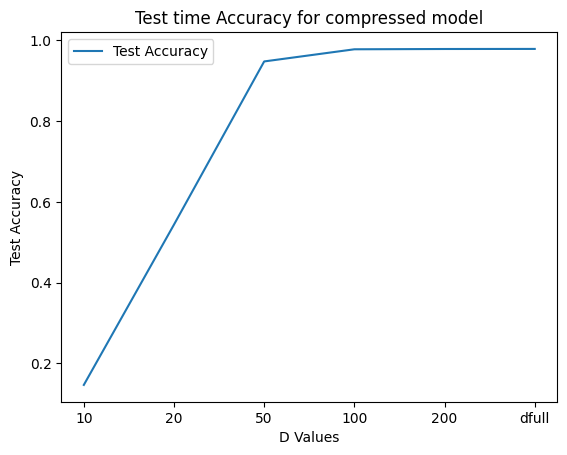

In [23]:
x_values = [10, 20, 50, 100, 200, 'dfull']

# Create a line plot
plt.plot(x_values, test_acc_list, label='Test Accuracy')


plt.xlabel('D Values')
plt.ylabel('Test Accuracy')
plt.title('Test time Accuracy for compressed model')

plt.legend()
plt.show()

## Inference

The baseline model achieved a test time accuracy of approximately 98.26% with a total of 5,012,490 parameters. The subsequent six SVDed versions with different values of D (10, 20, 50, 100, 200, and Dfull) were evaluated, each showcasing varying levels of compression.

Compressed Model with D value 10:
Test Time Accuracy: 16.61%
Parameters: 110,750

Compressed Model with D value 20:
Test Time Accuracy: 49.77%
Parameters: 212,250

Compressed Model with D value 50:
Test Time Accuracy: 97.11%
Parameters: 522,750

Compressed Model with D value 100:
Test Time Accuracy: 98.07%
Parameters: 1,060,250

Compressed Model with D value 200:
Test Time Accuracy: 98.14%
Parameters: 2,210,250

Compressed Model with D value Dfull:
Test Time Accuracy: 98.10%
Parameters: 14,625,290

### Weight Visuvalization of Baseline Model and Dfull Model

In [24]:
index = 1

for i in range(1,16,3):
  plt.figure(figsize=(16, 5))
  baseline_weights = baseline_model.layers[index].get_weights()[0]

  compressed_weights_u = compressed_model_list[1].layers[i].get_weights()[0]
  compressed_weights_s = compressed_model_list[1].layers[i+1].get_weights()[0]
  compressed_weights_v = compressed_model_list[1].layers[i+2].get_weights()[0]

  plt.subplot(1, 4, 1)
  plt.imshow(baseline_weights, cmap='viridis', aspect='auto')
  plt.title('Baseline Model Weights Layer '+str(index))
  plt.xlabel('Weights')
  plt.ylabel('Weights')
  plt.colorbar()

  plt.subplot(1, 4, 2)
  plt.imshow(compressed_weights_u, cmap='viridis', aspect='auto')
  plt.title('d = 20 Compressed Model Weights Layer '+str(i)+ ' (u)')
  plt.xlabel('Weights')
  plt.ylabel('Weights')
  plt.colorbar()

  plt.subplot(1, 4, 3)
  plt.imshow(compressed_weights_s, cmap='viridis', aspect='auto')
  plt.title('d = 20 Compressed Model Weights Layer '+str(i+1)+ ' (s)')
  plt.xlabel('Weights')
  plt.ylabel('Weights')
  plt.colorbar()

  plt.subplot(1, 4, 4)
  plt.imshow(compressed_weights_v, cmap='viridis', aspect='auto')
  plt.title('d = 20 Compressed Model Weights Layer '+str(i+2)+ ' (v)')
  plt.xlabel('Weights')
  plt.ylabel('Weights')
  plt.colorbar()

  plt.tight_layout()

  plt.show()
  index += 1

Output hidden; open in https://colab.research.google.com to view.